In [1]:
import context

from G4EPP import api, RadiationAnalysis

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

Api = api()

from scipy.io import loadmat

In [2]:
runList = Api.get_run_list()
PAlist  = Api.get_PA_list()

profiles = Api.get_all_ionization_profiles()
#profiles[:, 0, 11] = np.zeros([500,])  # replace pesky 10 keV, 50 deg profile

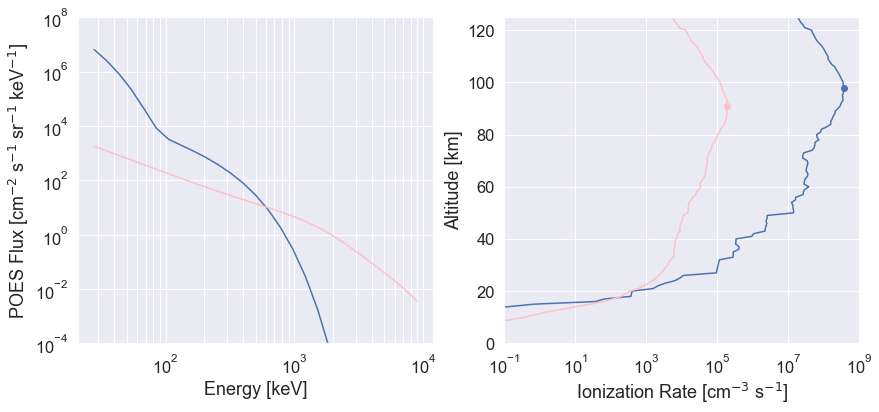

In [37]:
POESdata = loadmat("/home/grant/Downloads/POES_data/fluxes.mat")

plt.figure(figsize=(14,6)); plt.grid(True, which='both')

yp = np.zeros([len(runList), 3])

angArr = np.sin(np.deg2rad(PAlist))

#angArr = np.deg2rad(PAlist)

colArr = np.nansum(profiles * angArr[np.newaxis, np.newaxis, :], axis=2) * (15*(1 - np.cos(np.deg2rad(70))))

c = ['b', 'pink', 'purple']

R = [0, 1]


h = np.linspace(0, 499, 500)

for i in R:
    plt.subplot(1,2,1)
    plt.loglog(POESdata['energy'], POESdata['fluxes'][:,i], '-', color=c[i]);    
    
    yp[:,i] = np.interp(runList, POESdata['energy'].flatten(), POESdata['fluxes'][:,i])
    
    I = savgol_filter(np.dot(colArr, yp[:,i]), 11, 0)
    
    #plt.plot(runList, yp[:,i], 'o', color=c[i])
    
    plt.subplot(1,2,2)
    plt.semilogx(I * 1000/35 * 1e-6, h, color=c[i])
    
    
    indmax = np.argmax(I)
    
    plt.scatter(I[indmax] * 1000/35 * 1e-6, h[indmax], marker='o', color=c[i])
    
plt.subplot(1,2,1); plt.grid(True, which='both')        
plt.xlabel('Energy [keV]')
plt.ylabel('POES Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
plt.ylim([1e-4, 1e8])

plt.subplot(1,2,2); plt.grid(True, which='both')
plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]')
plt.ylabel('Altitude [km]')
plt.xlim([1e-1, 1e9]);
plt.ylim([0, 125])

plt.savefig('POES_flux.pdf', format='pdf', bbox_inches='tight');

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


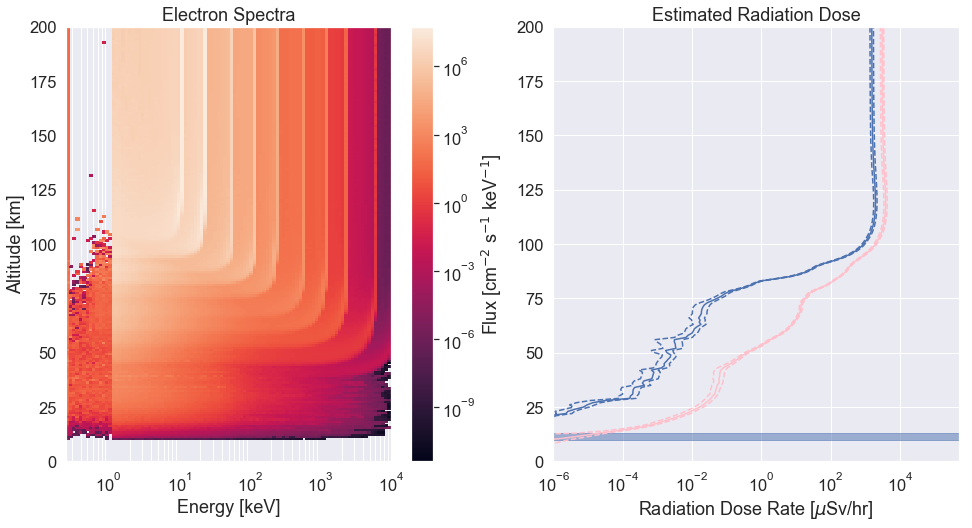

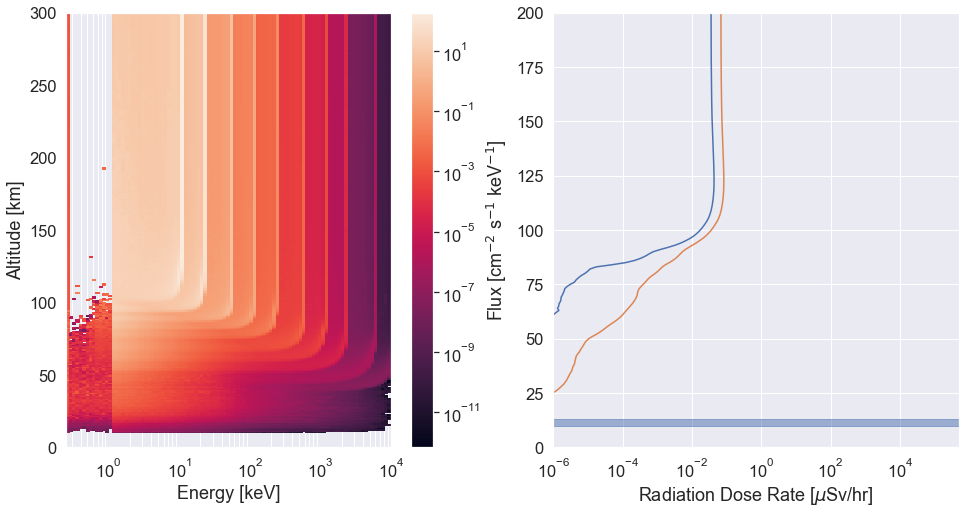

In [44]:
Rad = RadiationAnalysis(material='human')


SM = 7

spec_el = np.zeros([500, 100])
spec_ph = np.zeros([500, 100])

Vspec_el = np.zeros([500, 100])
Vspec_ph = np.zeros([500, 100])

A = yp/np.sum(yp, axis=0)

X,Y = Api.get_spectral_abscissa()
plt.figure(1, figsize=(16,8)); plt.subplot(1,2,1); plt.grid(True, which='both');
plt.figure(2, figsize=(16,8)); plt.subplot(1,2,1); plt.grid(True, which='both');

for i in R:
    
    power = np.trapz(POESdata['fluxes'][:,i], x=POESdata['energy'].flatten())
    
    for ind, ene in enumerate(runList):
        for ind2, ang in enumerate(PAlist):
            
            if ene == 10 and ang == 20:
                continue
                
            if ene == 10 and ang == 25:
                continue
                
            if ene == 10 and ang == 50:
                continue
                
            if ene == 50 and ang == 65:
                continue
                
            # Get the electron and photon profiles separately
            tmp_el, tmp2_el = Api.get_spectral_profile("mono", ene, A[ind,i], ang, particle="electron") / 10
            tmp_ph, tmp2_ph = Api.get_spectral_profile("mono", ene, A[ind,i], ang, particle="photon")   / 10
            
            
            spec_el = spec_el + np.sin(np.deg2rad(ang)) * tmp_el / (15 * (1 - np.cos(np.deg2rad(70))))
            spec_ph = spec_ph + np.sin(np.deg2rad(ang)) * tmp_ph / (15 * (1 - np.cos(np.deg2rad(70))))
            
            Vspec_el = Vspec_el + np.sin(np.deg2rad(ang)) * tmp2_el / (15 * (1 - np.cos(np.deg2rad(70))))
            Vspec_ph = Vspec_ph + np.sin(np.deg2rad(ang)) * tmp2_ph / (15 * (1 - np.cos(np.deg2rad(70))))

            '''
            spec_el = np.nansum(spec_el, 
                                np.sin(np.deg2rad(ang)) * tmp_el / (15 * (1 - np.cos(np.deg2rad(70)))))
            spec_ph = np.nansum(spec_ph, 
                                np.sin(np.deg2rad(ang)) * tmp_ph / (15 * (1 - np.cos(np.deg2rad(70)))))
            ''';
    
    
    
# Convert Sv -> uSv and sec -> hr 
    rad_profile = Rad.calculate_radiation_dose(spec_el, spec_ph) * 3600 * 1e6
    Vrad_profile = Rad.calculate_radiation_dose(Vspec_el, Vspec_ph) * 3600 * 1e6

    
    plt.figure(1); plt.subplot(1,2,2); plt.grid(True, which='both');
    plt.semilogx(1e-1*savgol_filter(rad_profile, SM, 0), np.linspace(0, 499, 500), c=c[i]);
    plt.semilogx(1e-1*savgol_filter(rad_profile + 5e4*Vrad_profile, SM, 0), np.linspace(0, 499, 500), 'k--', c=c[i]);
    plt.semilogx(1e-1*savgol_filter(rad_profile - 5e4*Vrad_profile, SM, 0), np.linspace(0, 499, 500), 'k--', c=c[i]);

    
    plt.figure(2); plt.subplot(1,2,2); plt.grid(True, which='both');
    plt.semilogx(savgol_filter(Vrad_profile, SM, 0), np.linspace(0, 499, 500));

plt.figure(1)
plt.subplot(1,2,2); plt.grid(True, which='both');    
plt.ylim([0, 200]);
plt.xlabel('Radiation Dose Rate [$\mu$Sv/hr]');
#plt.ylabel('Altitude [km]');
plt.xlim([1e-6, 5e5]);
plt.title('Estimated Radiation Dose')

plt.fill_between([1e-6, 5e5], 10, 13, color='b', alpha=0.5)

    
plt.subplot(1,2,1)
plt.pcolormesh(X,Y, spec_el, norm=LogNorm());
plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');
plt.xscale('log');
plt.ylabel('Altitude [km]');
plt.xlabel('Energy [keV]')
plt.ylim([0, 200]);
plt.title('Electron Spectra')


plt.savefig('POES_dose.pdf', format='pdf', bbox_inches='tight')

plt.figure(2)
plt.subplot(1,2,2); plt.grid(True, which='both');    
plt.ylim([0, 200]);
plt.xlabel('Radiation Dose Rate [$\mu$Sv/hr]');
#plt.ylabel('Altitude [km]');
plt.xlim([1e-6, 5e5]);

plt.fill_between([1e-8, 5e5], 10, 13, color='b', alpha=0.5)


plt.subplot(1,2,1)
plt.pcolormesh(X,Y, Vspec_el, norm=LogNorm());
plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');
plt.xscale('log');
plt.ylabel('Altitude [km]');
plt.xlabel('Energy [keV]')
plt.ylim([0, 300]);

# 3rd Order 1D Clenshaw-Curtis Integration

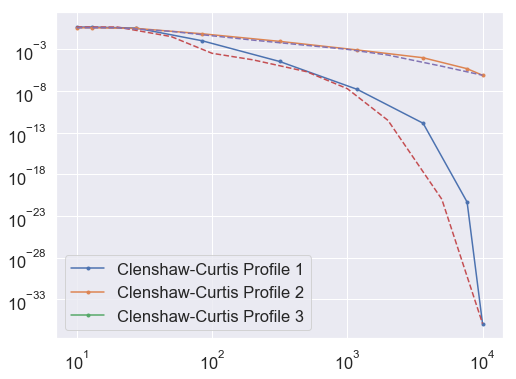

In [15]:
x = np.array([
  [  1.0000],
  [  0.9239],
  [  0.7071],
  [  0.3827],
  [  0.0000],
  [ -0.3827],
  [ -0.7071],
  [ -0.9239],
  [ -1.0000]])

# [-1, 1] -> [0, 1]
x = x * 0.5 + 0.5;

# [0, 1] -> [1, 4]
x = x * 3 + 1

# [1, 4] -> [10^1, 10^4]
xp = 10**x

w = np.array([
  [ 0.0159], 
  [ 0.1462],
  [ 0.2794],
  [ 0.3617],
  [ 0.3937],
  [ 0.3617],
  [ 0.2794],
  [ 0.1462],
  [ 0.0159]])


B0 = np.interp(xp, runList, A[:,0])
B1 = np.interp(xp, runList, A[:,1])
B2 = np.interp(xp, runList, A[:,2])

plt.figure(figsize=(8,6))
plt.loglog(xp, B0, '.-', label='Clenshaw-Curtis Profile 1')
plt.loglog(xp, B1, '.-', label='Clenshaw-Curtis Profile 2')
plt.loglog(xp, B2, '.-', label='Clenshaw-Curtis Profile 3')

plt.loglog(runList, A[:,0], '--', label=None);
plt.loglog(runList, A[:,1], '--', label=None);
plt.loglog(runList, A[:,2], '--', label=None); 

plt.legend();